In [2]:
import cv2 as cv
import numpy as np
from IPython.display import Image, display
import math
from numpy.linalg import norm

In [3]:
import PIL.Image
import io
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [5]:
file = 'patitos.mp4'
cap = cv.VideoCapture(file)

orig_img = frame.copy()
edges = cv.Canny(frame,50,250)
edges = cv.dilate(edges.astype('uint8'), np.ones((2,2), np.uint8), iterations=3)
#edges = cv.blur(edges, (2,2))

lines = cv.HoughLinesP(edges, 1, np.pi/180, 200, minLineLength=200, maxLineGap=20)
line_img = frame.copy()
for line in lines:
    x1,y1,x2,y2 = line[0]
    cv.line(line_img,(x1,y1),(x2,y2),(0,255,0),1)
showarray(line_img)

AttributeError: 'cv2.VideoCapture' object has no attribute 'copy'

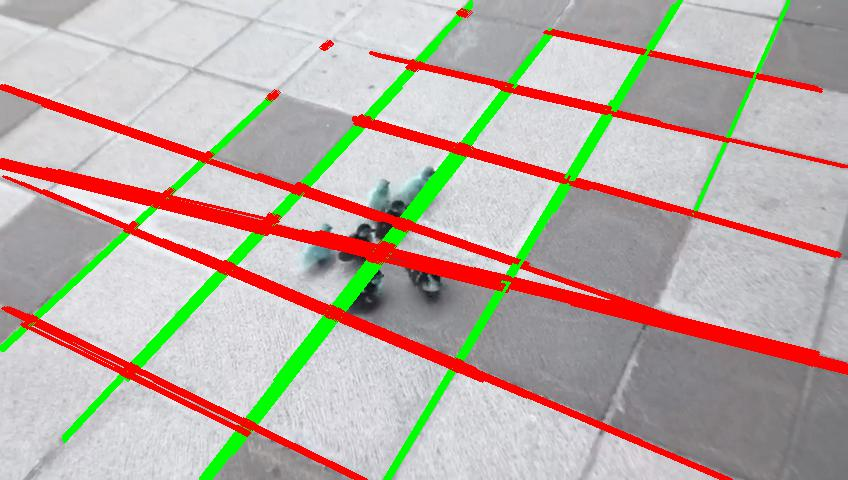

In [71]:
from skspatial.objects import Line

def check_intersection(line1, line2):
    line1_sk = Line.from_points(line1[:2], line1[2:])
    line2_sk = Line.from_points(line2[:2], line2[2:])

    try:
        intersect = line1_sk.intersect_line(line2_sk)
    except ValueError:
        return False, None

    return True, intersect

def cos_similarity(line1, line2):
    A = np.array(line1[:2] - line1[2:])
    B = np.array(line2[:2] - line2[2:])
    return np.dot(A,B)/(norm(A) * norm(B))

points = []
for i,l1 in enumerate(lines):
    for j,l2 in enumerate(lines):
        if i == j:
            continue
        similarity = cos_similarity(l1[0], l2[0])
        #print(l1[0][2])
        has_intersect, point = check_intersection(l1[0].astype(float), l2[0].astype(float))
        if has_intersect and similarity < 0.6:
            oob = np.any(point > frame.shape[:2]) | np.any(point < 0)
            if not oob:
                points.append(point)


point_frame = line_img.copy()
for point in points:
    cv.circle(point_frame, center=(point[0].astype('uint32'), point[1].astype('uint32')), radius=2, color=(255,0,0))
showarray(point_frame)

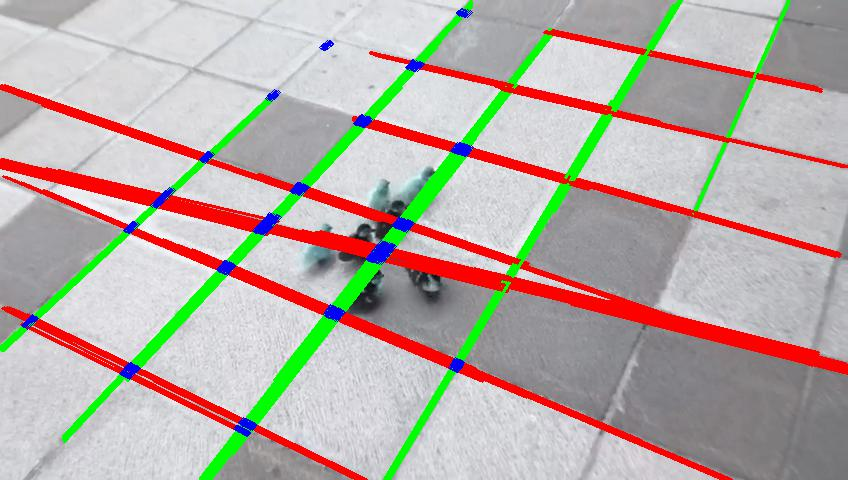

In [72]:
# Calculate angle for all lines, group together with k-means
from sklearn.cluster import KMeans

def line_angle(line):
    return np.arctan2(line[0] - line[2], line[1] - line[3])

X = [line_angle(l[0]) for l in lines]
line_cluster = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(np.array([X]).reshape(-1,1))

line_img = frame.copy()
for line in lines:
    angle = line_angle(line[0])
    category = line_cluster.predict(np.array([angle]).reshape(-1,1))[0]
    x1,y1,x2,y2 = line[0]
    if category == 0:
        color = (255, 0, 0)
    elif category == 1:
        color = (0, 255, 0)
    cv.line(line_img,(x1,y1),(x2,y2),color,2)
#showarray(line_img)

# Now we have two cateogires, vertical and horizontal lines, look for intersections between vert and horiz
lines_a, lines_b = [], []
for l in lines:
    angle = line_angle(line[0])
    category = line_cluster.predict(np.array([angle]).reshape(-1,1))[0]
    if category == 0:
        lines_a.append(line)
    elif category == 1:
        lines_b.append(line)

for i,l1 in enumerate(lines_a):
    for j,l2 in enumerate(line_b):
        similarity = cos_similarity(l1[0], l2[0])
        has_intersect, point = check_intersection(l1[0].astype(float), l2[0].astype(float))
        if has_intersect and similarity < 0.6:
            oob = np.any(point > frame.shape[:2]) | np.any(point < 0)
            if not oob:
                points.append(point)

point_frame = line_img.copy()
for point in points:
    cv.circle(point_frame, center=(point[0].astype('uint32'), point[1].astype('uint32')), radius=2, color=(0,0,255))
showarray(point_frame)

In [41]:
kmeans.cluster_centers_

array([[-1.87949754],
       [-0.67108117]])

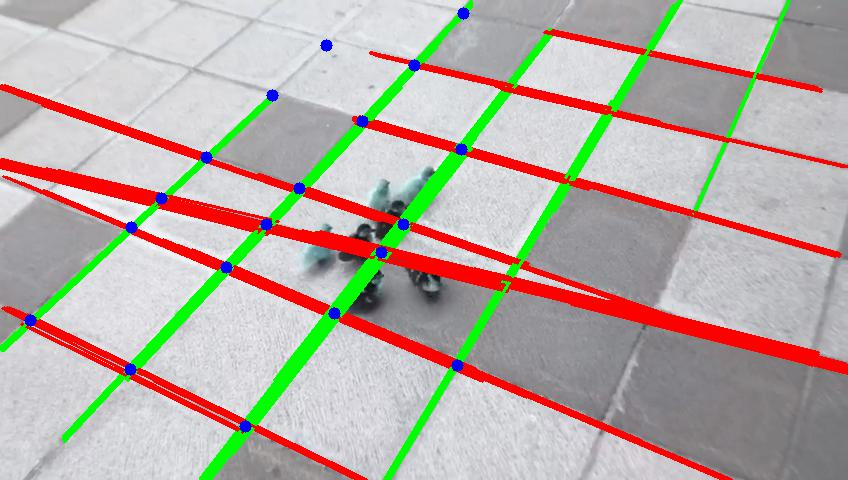

In [70]:
from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth = estimate_bandwidth(points, quantile=0.025, n_samples=500)
clustering = MeanShift(bandwidth=bandwidth).fit(points)
centers = clustering.cluster_centers_
cluster_frame = line_img.copy()
for point in centers:
    cv.circle(cluster_frame, center=(point[0].astype('uint32'), point[1].astype('uint32')), thickness=-1, radius=6, color=(0,0,255))
showarray(cluster_frame)

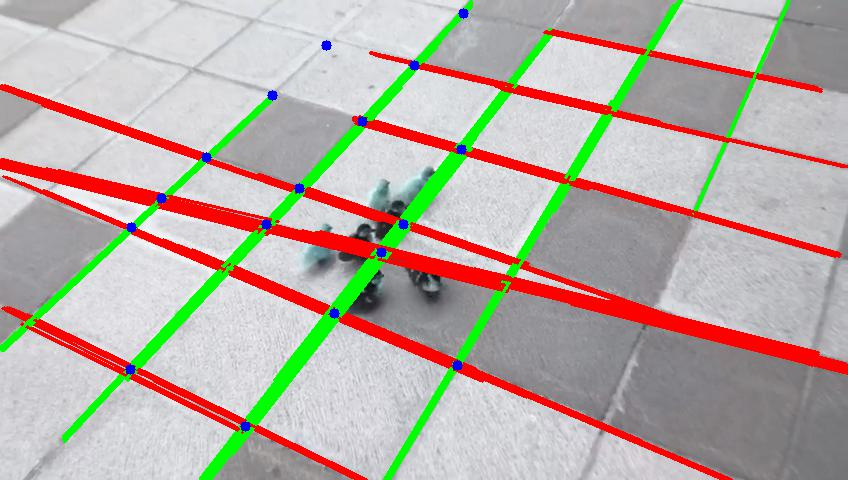

In [119]:
from sklearn.linear_model import RANSACRegressor

X = centers[:, 0].reshape(-1, 1)  # Input features (x-coordinate)
y = centers[:, 1]  # Target variable (y-coordinate)

ransac = RANSACRegressor(random_state=0)
ransac.fit(X, y)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Filter points based on residuals
residuals = np.abs(ransac.predict(X) - y)
residual_threshold = 5  # Adjust this threshold as needed
filtered_points = centers[residuals > residual_threshold]

ransac_img = line_img.copy()
for point in filtered_points:
    cv.circle(ransac_img, tuple(point.astype(int)[:2]), 5, (0, 0, 255), -1)
showarray(ransac_img)

In [109]:
residuals

array([ 33.46791302,  29.67948949,  12.02004986,  45.43356969,
        79.65693367, 166.01258967,  54.95462965,  86.78940759,
       103.74521812,   1.43733572,  75.05000042, 168.93917733,
       143.57038495, 272.81720523, 114.90832693, 156.63861329,
        67.48217307,   4.08237078, 190.43010453, 181.220519  ])